In [1]:
import xarray as xr
import cfgrib
import numpy as np
import matplotlib.pyplot as plt

from data_processor import DataProcessor
from regressor import Regressor

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp), axis=-1)

In [4]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 3
fh = 2

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=True)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [5]:
X.shape, y.shape

((1428, 25, 45, 5, 3, 6), (1428, 25, 45, 2, 6))

<LINEAR>
t2m => RMSE:  3.75883; SE: 0.026842506518532167
sp => RMSE:  13.57828; SE: 0.4096169310028005
tcc => RMSE:  0.31429; SE: 0.00476475155158956
u10 => RMSE:  3.02143; SE: 0.03662939791974631
v10 => RMSE:  3.5153; SE: 0.043680050482055977
tp => RMSE:  0.00053; SE: 4.16941868965454e-06


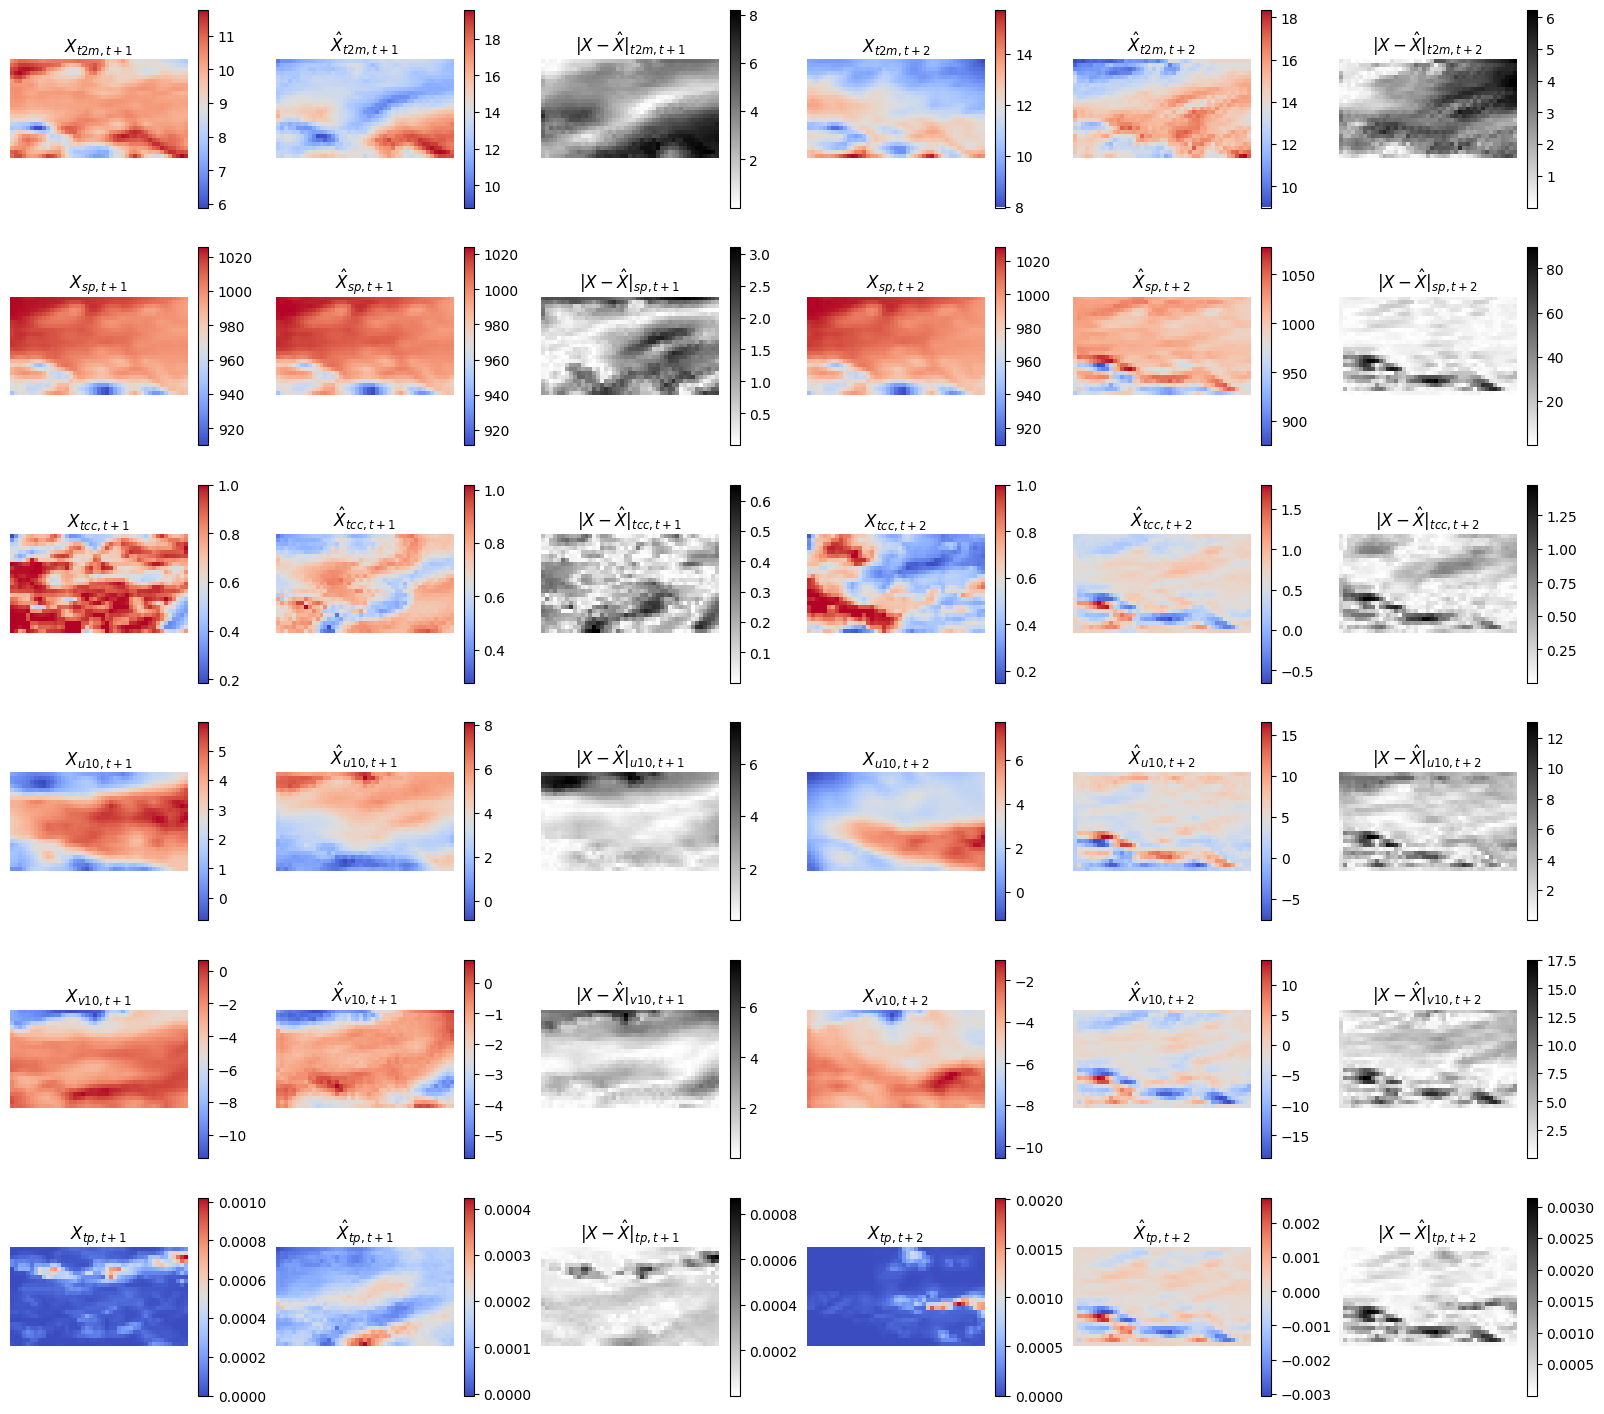

Evaluation metrics for entire test set:
t2m => RMSE: 2.638; SE: 0.00722035292861406
sp => RMSE: 13.767; SE: 0.02618677773034291
tcc => RMSE: 0.341; SE: 0.0003406819090355946
u10 => RMSE: 2.688; SE: 0.003557221413840321
v10 => RMSE: 3.075; SE: 0.002911139152650285
tp => RMSE: 0.001; SE: 2.454296631825404e-07


 85.12860131263733 [S]


In [6]:
from time import time 
start = time()

available_reg = ['linear']
for reg in available_reg:
    print(f'<{reg.upper()}>')
    linearreg = Regressor(X.shape, fh, feature_list, regressor_type=reg)
    linearreg.train(X_train, y_train)
    _ = linearreg.predict_and_evaluate(X_test, y_test, max_samples=1)
    print()
    
stop = time()
print('\n', stop-start, '[S]')